In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [16]:
# Load the dataset
data = pd.read_csv('/content/asthma_disease_data.csv')

# Drop columns that should not be used as features
data = data.drop(columns=['DoctorInCharge'])

# Basic data cleaning (handling missing values, encoding categorical features, etc.)
data = data.dropna()  # Drop rows with missing values

In [17]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'PhysicalActivity',
                       'DietQuality', 'SleepQuality', 'PollutionExposure', 'PollenExposure',
                       'DustExposure', 'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies',
                       'Eczema', 'HayFever', 'GastroesophagealReflux']

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [18]:
# Feature scaling
scaler = StandardScaler()
numeric_columns = ['Age', 'BMI', 'LungFunctionFEV1', 'LungFunctionFVC']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [19]:
#Plotting function
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values from the results dictionary
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values from the results dictionary
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()


In [20]:
class AsthmaDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data.iloc[idx].values.astype(np.float32)
        y = np.array(self.target.iloc[idx]).astype(np.float32)  # Correctly convert the target value to a numpy array
        return torch.tensor(x), torch.tensor(y)


In [21]:
# Define target variables for different models
target_diagnosis = data['Diagnosis']
target_severity = data[['Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms']]
target_exacerbations = (data[['Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms']].sum(axis=1) > 2).astype(int)
target_risk_factors = data[['Smoking', 'PollutionExposure', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever']]

# Drop target columns from the data
data = data.drop(columns=['Diagnosis', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms'])

# Ensure all remaining columns are numeric
assert all(data.dtypes != 'object')

# Train-test split for each model
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(data, target_diagnosis, test_size=0.2, random_state=42)
X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(data, target_severity, test_size=0.2, random_state=42)
X_train_exacerbations, X_test_exacerbations, y_train_exacerbations, y_test_exacerbations = train_test_split(data, target_exacerbations, test_size=0.2, random_state=42)
X_train_risk_factors, X_test_risk_factors, y_train_risk_factors, y_test_risk_factors = train_test_split(data, target_risk_factors, test_size=0.2, random_state=42)


In [22]:
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis

(      PatientID       Age  Gender  Ethnicity  EducationLevel       BMI  \
 642        5676 -0.191553       0          0               3  1.702362   
 1752       6786  1.289782       1          1               2  0.130321   
 1401       6435 -0.145262       0          0               1  0.079654   
 2032       7066  0.086197       1          3               2 -0.495270   
 990        6024 -1.719180       1          3               1  1.250944   
 ...         ...       ...     ...        ...             ...       ...   
 1638       6672  0.965740       0          3               1  0.069585   
 1095       6129  1.660115       1          0               1 -1.682501   
 1130       6164  0.873156       0          0               2 -0.894009   
 1294       6328 -1.487721       0          0               0  1.275620   
 860        5894 -0.885929       1          0               1  0.799286   
 
       Smoking  PhysicalActivity  DietQuality  SleepQuality  ...  DustExposure  \
 642         0  

In [23]:
# Create DataLoader for each model
batch_size = 32

train_loader_diagnosis = DataLoader(AsthmaDataset(X_train_diagnosis, y_train_diagnosis), batch_size=batch_size, shuffle=True)
test_loader_diagnosis = DataLoader(AsthmaDataset(X_test_diagnosis, y_test_diagnosis), batch_size=batch_size, shuffle=False)

train_loader_severity = DataLoader(AsthmaDataset(X_train_severity, y_train_severity), batch_size=batch_size, shuffle=True)
test_loader_severity = DataLoader(AsthmaDataset(X_test_severity, y_test_severity), batch_size=batch_size, shuffle=False)

train_loader_exacerbations = DataLoader(AsthmaDataset(X_train_exacerbations, y_train_exacerbations), batch_size=batch_size, shuffle=True)
test_loader_exacerbations = DataLoader(AsthmaDataset(X_test_exacerbations, y_test_exacerbations), batch_size=batch_size, shuffle=False)

train_loader_risk_factors = DataLoader(AsthmaDataset(X_train_risk_factors, y_train_risk_factors), batch_size=batch_size, shuffle=True)
test_loader_risk_factors = DataLoader(AsthmaDataset(X_test_risk_factors, y_test_risk_factors), batch_size=batch_size, shuffle=False)

In [24]:
#Model definition:
class AsthmaModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AsthmaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

        #return self.fc3(self.dropout(self.relu(self.fc2(self.dropout(self.relu(self.fc1(x))))))) #You can also run this as the forward

In [25]:
from tqdm.auto import tqdm

#Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    results = {
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": []
    }

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        results["train_loss"].append(epoch_loss)
        results["train_acc"].append(epoch_accuracy)

        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.long())
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = correct / total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_accuracy)

        model.train()  # Switch back to training mode

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}')

    return model, results

In [26]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model, criterion, and optimizer
input_dim = data.shape[1]
output_dim = 2  # Assuming binary classification for diagnosis

model_diagnosis = AsthmaModel(input_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_diagnosis.parameters(), lr=0.001)


In [27]:
# Train the model and get the results
num_epochs = 25
model_diagnosis, results = train_model(model_diagnosis, train_loader_diagnosis, test_loader_diagnosis, criterion, optimizer, num_epochs)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25, Train Loss: 17.3083, Train Accuracy: 0.8970, Test Loss: 5.1651, Test Accuracy: 0.9520
Epoch 2/25, Train Loss: 3.7616, Train Accuracy: 0.8829, Test Loss: 0.7747, Test Accuracy: 0.9520
Epoch 3/25, Train Loss: 1.4583, Train Accuracy: 0.8913, Test Loss: 0.2655, Test Accuracy: 0.9520
Epoch 4/25, Train Loss: 0.6866, Train Accuracy: 0.9096, Test Loss: 0.3836, Test Accuracy: 0.9520
Epoch 5/25, Train Loss: 0.4679, Train Accuracy: 0.9341, Test Loss: 0.4192, Test Accuracy: 0.9520
Epoch 6/25, Train Loss: 0.3778, Train Accuracy: 0.9394, Test Loss: 0.3120, Test Accuracy: 0.9520
Epoch 7/25, Train Loss: 0.3266, Train Accuracy: 0.9373, Test Loss: 0.2211, Test Accuracy: 0.9520
Epoch 8/25, Train Loss: 0.3309, Train Accuracy: 0.9430, Test Loss: 0.3021, Test Accuracy: 0.9520
Epoch 9/25, Train Loss: 0.2975, Train Accuracy: 0.9425, Test Loss: 0.2319, Test Accuracy: 0.9520
Epoch 10/25, Train Loss: 0.3186, Train Accuracy: 0.9462, Test Loss: 0.2393, Test Accuracy: 0.9520
Epoch 11/25, Train Loss: 0.2

In [28]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')


In [29]:
# Evaluate the diagnosis model
evaluate_model(model_diagnosis, test_loader_diagnosis)

Accuracy: 0.9520


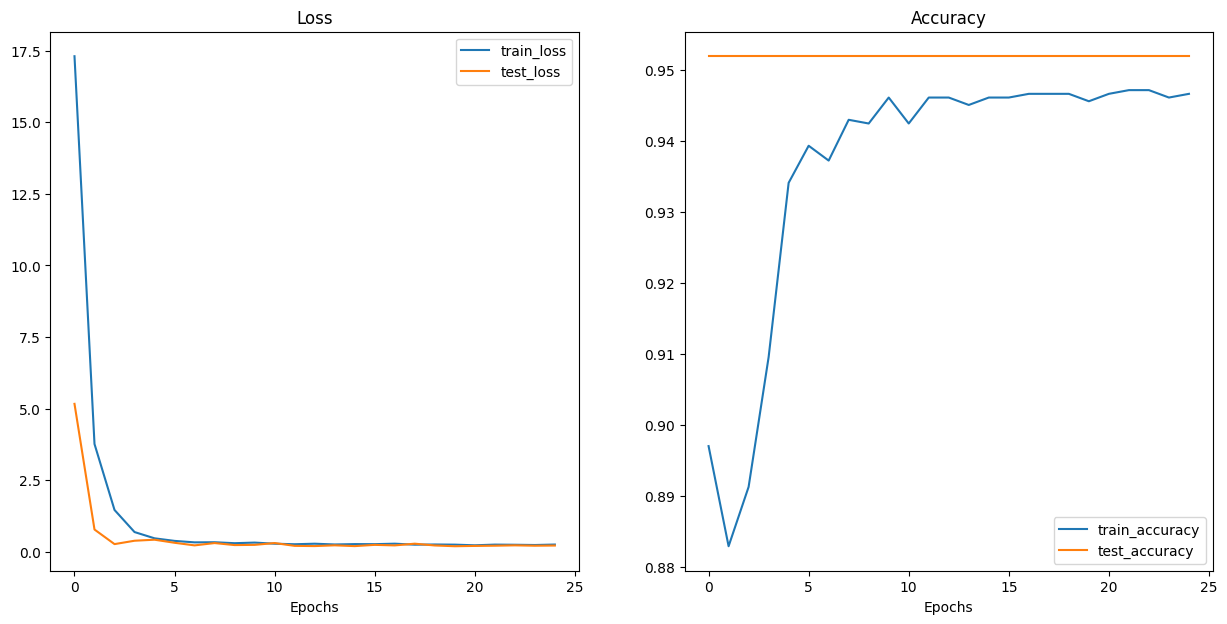

In [30]:
# Plot the training curves
plot_loss_curves(results)

In [67]:
# Assuming your model expects 128 features

def preprocess_input(data, label_encoders, scaler, categorical_columns, numeric_columns):
    """
    Preprocess the input data in the same way as the training data.
    """
    # Convert data to DataFrame if not already
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=numeric_columns + categorical_columns)

    # Encode categorical variables
    for column in categorical_columns:
        le = label_encoders[column]
        # Convert to string to ensure consistency with label encoders
        data[column] = data[column].astype(str)
        # Handle unseen labels
        data[column] = data[column].apply(lambda x: x if x in le.classes_ else le.classes_[0])
        # Transform using the label encoder
        data[column] = le.transform(data[column])

    # Scale numeric features
    data[numeric_columns] = scaler.transform(data[numeric_columns])

    # Convert to numpy array and then to torch tensor
    processed_data = data.values.astype(np.float32)
    processed_data = torch.tensor(processed_data)  # Ensure it's a torch tensor

    return processed_data


In [56]:
def make_prediction(model, input_data, label_encoders, scaler, categorical_columns, numeric_columns):
    """
    Make a prediction using the trained model.

    Args:
        model: Trained PyTorch model.
        input_data: DataFrame containing the new data.
        label_encoders: Dictionary of label encoders used for categorical columns.
        scaler: Scaler used for numerical columns.
        categorical_columns: List of categorical column names.
        numeric_columns: List of numerical column names.

    Returns:
        predictions: Model predictions.
    """
    model.eval()

    # Preprocess the input data
    input_data = preprocess_input(input_data, label_encoders, scaler, categorical_columns, numeric_columns)

    # Move the data to the appropriate device
    input_data = input_data.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_data)
        _, predictions = torch.max(outputs, 1)

    return predictions.cpu().numpy()


In [68]:
# Example usage:
# Load or create a DataFrame with new data
new_data = pd.DataFrame({
    'Age': [45],
    'Gender': ['Female'],
    'Ethnicity': ['Caucasian'],
    'EducationLevel': ['College'],
    'BMI': [29.91029825809871],
    'Smoking': ['No'],
    'PhysicalActivity': [2.895720176719403],
    'DietQuality': [2.6077004679895364],
    'SleepQuality': [7.2349084771854155],  # Unseen label (handled appropriately)
    'PollutionExposure': [1.7117219761520086],
    'PollenExposure': [0.7414487929922242],
    'DustExposure': [6.466790407464899],
    'PetAllergy': ['No'],
    'FamilyHistoryAsthma': ['Yes'],
    'HistoryOfAllergies': ['Yes'],
    'Eczema': ['No'],
    'HayFever': ['No'],
    'GastroesophagealReflux': ['No'],
    'LungFunctionFEV1': [2.848420334462916],
    'LungFunctionFVC': [5.771022308077478]
})

# Preprocess input data
processed_data = preprocess_input(new_data, label_encoders, scaler, categorical_columns, numeric_columns)

# Ensure processed_data has the correct shape
print(processed_data.shape)  # Should print torch.Size([1, 22]) if 22 features are expected by the model

# Make prediction with all required arguments
predictions = make_prediction(model_diagnosis, processed_data, label_encoders, scaler, categorical_columns, numeric_columns)
print(f'Predicted class: {predictions[0]}')


torch.Size([1, 20])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x20 and 22x128)